In [1]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

#from string import ascii_letters

In [2]:
df =pd.read_pickle('../pickle_pd/second_pd_top_25.pkl')
#features = ['lep_pt_2','lep_pt_1','jet_n','lep_E_1','jet_pt_0','lep_eta_0','jet_pt_1','lep_pt_0','lep_E_2','lep_eta_1','lep_phi_1','lep_phi_0',
#            'lep_ptcone30_1','lep_ptcone30_0','jet_eta_0','jet_m','lep_E_0','jet_eta_1','jet_pt_2','lep_pt_3','jet_E_0','lep_charge_1','lep_charge_0','lep_E_3']

In [5]:
qt = QuantileTransformer(random_state=0)
df[features] = qt.fit_transform(df[features])

In [6]:
df[features] = qt.fit_transform(df[features])

In [7]:
df.head()

,lep_pt_2,met_et,lep_pt_1,jet_n,lep_eta_0,lep_E_1,jet_pt_0,jet_pt_1,lep_eta_1,lep_pt_0,...,lep_E_0,lep_phi_0,jet_eta_1,jet_pt_2,lep_pt_3,jet_E_0,lep_charge_1,lep_charge_0,jet_E_1,label
0,0.827000,0.380513,0.876876,0.000000,0.307938,0.680041,0.000000,0.0,0.302565,0.674032,...,0.455602,0.524371,0.502503,0.0,0.000000,0.000000,0.000000,1.0,0.0,0
1,0.000000,0.087915,0.823059,0.000000,0.637296,0.633649,0.000000,0.0,0.693463,0.548498,...,0.294748,0.793942,0.502503,0.0,0.000000,0.000000,0.000000,1.0,0.0,0
2,0.889522,0.105200,0.944172,0.413914,0.912925,0.818662,0.332354,0.0,0.804912,0.456675,...,0.732645,0.350029,0.502503,0.0,0.955404,0.402943,0.000000,1.0,0.0,0
3,0.959527,0.135239,0.738830,0.000000,0.492951,0.898281,0.000000,0.0,0.941287,0.065096,...,0.010253,0.548934,0.502503,0.0,0.973738,0.000000,1.000000,0.0,0.0,0
4,0.000000,0.789773,0.000000,0.413914,0.493724,0.000000,0.906895,0.0,0.502002,0.796176,...,0.473130,0.369509,0.502503,0.0,0.000000,0.772677,0.504004,1.0,0.0,0


In [8]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], df['label'], test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [9]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 1,30,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [10]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, #eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    pred_val = clf.predict(X_test)
    val_accuracy = accuracy_score(y_test, pred_val)
    delta_accuracy = accuracy - val_accuracy
    print ("SCORE:", accuracy)
    return {'loss': -val_accuracy, 'accuracy': accuracy, 'val_accuracy': val_accuracy, 'delta_accuracy':delta_accuracy, 'status': STATUS_OK }

In [11]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                                              | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8070116476699859                                                                        
  2%|▍                  | 1/50 [00:26<21:52, 26.78s/trial, best loss: -0.8050431626352733]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8057313322002542                                                                        
  4%|▊                  | 2/50 [00:58<23:32, 29.44s/trial, best loss: -0.8051295839294802]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8051935997029668                                                                        
  6%|█▏                 | 3/50 [01:17<19:23, 24.75s/trial, best loss: -0.8051295839294802]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8055168793590741                                                                        
  8%|█▌                 | 4/50 [01:39<18:13, 23.78s/trial, best loss: -0.8051295839294802]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8059425842527599                                                                        
 10%|██                  | 5/50 [02:06<18:48, 25.08s/trial, best loss: -0.805302426517894]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8058209542831354                                                                        
 12%|██▎                | 6/50 [02:22<15:59, 21.81s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.805836958226507                                                                         
 14%|██▋                | 7/50 [02:43<15:24, 21.51s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8053792454460779                                                                        
 16%|███                | 8/50 [03:07<15:39, 22.37s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8055680919778634                                                                        
 18%|███▍               | 9/50 [03:58<21:29, 31.45s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.805875367690599                                                                         
 20%|███▌              | 10/50 [04:36<22:10, 33.26s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8052416115330817                                                                        
 22%|███▉              | 11/50 [04:55<18:50, 28.99s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8071236752735874                                                                        
 24%|████▎             | 12/50 [05:15<16:37, 26.26s/trial, best loss: -0.8053312336159629]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8060354071243154                                                                        
 26%|████▋             | 13/50 [05:35<14:58, 24.28s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8055712927665377                                                                        
 28%|█████             | 14/50 [06:03<15:15, 25.44s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8052672178424763                                                                        
 30%|█████▍            | 15/50 [06:44<17:34, 30.13s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8062306552334495                                                                        
 32%|█████▊            | 16/50 [07:26<19:05, 33.69s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8060642142223844                                                                        
 34%|██████            | 17/50 [08:12<20:38, 37.53s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8056353085400243                                                                        
 36%|██████▍           | 18/50 [09:20<24:47, 46.49s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8056481116947216                                                                        
 38%|██████▊           | 19/50 [10:12<24:56, 48.28s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8088937114104916                                                                        
 40%|███████▏          | 20/50 [10:57<23:39, 47.32s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.814389465564315                                                                         
 42%|███████▌          | 21/50 [11:39<22:07, 45.76s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8107309641095566                                                                        
 44%|███████▉          | 22/50 [12:18<20:19, 43.56s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8072357028771889                                                                        
 46%|████████▎         | 23/50 [13:06<20:11, 44.86s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8080487032004686                                                                        
 48%|████████▋         | 24/50 [13:40<18:04, 41.71s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8062946710069361                                                                        
 50%|█████████         | 25/50 [14:20<17:12, 41.29s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.805827355860484                                                                         
 52%|█████████▎        | 26/50 [14:58<16:03, 40.13s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8055200801477485                                                                        
 54%|█████████▋        | 27/50 [15:35<15:01, 39.19s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8057921471850664                                                                        
 56%|██████████        | 28/50 [16:12<14:09, 38.61s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8056097022306297                                                                        
 58%|██████████▍       | 29/50 [16:49<13:18, 38.02s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8059041747886679                                                                        
 60%|██████████▊       | 30/50 [17:24<12:25, 37.29s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.805612903019304                                                                         
 62%|███████████▏      | 31/50 [18:06<12:12, 38.55s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8053056273065683                                                                        
 64%|███████████▌      | 32/50 [18:45<11:35, 38.65s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8069764389945683                                                                        
 66%|███████████▉      | 33/50 [19:41<12:27, 43.95s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8058081511284381                                                                        
 68%|████████████▏     | 34/50 [20:19<11:15, 42.21s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8053536391366832                                                                        
 70%|████████████▌     | 35/50 [20:38<08:48, 35.24s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8055360840911201                                                                        
 72%|████████████▉     | 36/50 [21:14<08:17, 35.54s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.805292824151871                                                                         
 74%|█████████████▎    | 37/50 [21:59<08:17, 38.24s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8057057258908595                                                                        
 76%|█████████████▋    | 38/50 [22:34<07:27, 37.27s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8054496627969132                                                                        
 78%|██████████████    | 39/50 [23:15<07:04, 38.55s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8050751705220166                                                                        
 80%|██████████████▍   | 40/50 [23:35<05:29, 32.95s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8060322063356411                                                                        
 82%|██████████████▊   | 41/50 [24:22<05:34, 37.13s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8054144541214955                                                                        
 84%|███████████████   | 42/50 [24:54<04:44, 35.58s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8051359855068289                                                                        
 86%|███████████████▍  | 43/50 [25:22<03:52, 33.26s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8054944738383538                                                                        
 88%|███████████████▊  | 44/50 [25:59<03:26, 34.41s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8056481116947216                                                                        
 90%|████████████████▏ | 45/50 [26:43<03:06, 37.34s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.806915624009756                                                                         
 92%|████████████████▌ | 46/50 [27:18<02:25, 36.48s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8057953479737407                                                                        
 94%|████████████████▉ | 47/50 [27:54<01:49, 36.49s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8053344344046373                                                                        
 96%|█████████████████▎| 48/50 [28:29<01:11, 35.85s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.8062370568107982                                                                        
 98%|█████████████████▋| 49/50 [28:58<00:33, 33.93s/trial, best loss: -0.8056961235248365]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                    
0.806352285203074                                                                         
100%|██████████████████| 50/50 [29:47<00:00, 35.76s/trial, best loss: -0.8056961235248365]


In [13]:
best_hyperparams

{'colsample_bytree': 0.8627030660880632,
 'gamma': 4.032606881020913,
 'max_depth': 4.0,
 'min_child_weight': 8.0,
 'reg_alpha': 3.0,
 'reg_lambda': 0.8601590513309169}

In [16]:
trial_res

,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,reg_lambda,accuracy,val_accuracy,delta_accuracy,hue
0,0.745868,1.808007,11.0,1.0,13.0,0.392972,0.807012,0.805043,0.001968,0.0
1,0.999538,6.693717,16.0,7.0,9.0,0.061095,0.805731,0.805130,0.000602,0.0
2,0.526800,8.477112,7.0,1.0,18.0,0.081229,0.805194,0.804851,0.000342,0.0
3,0.795067,4.907461,17.0,8.0,27.0,0.278809,0.805517,0.805043,0.000474,0.0
4,0.837484,3.522582,12.0,10.0,12.0,0.697864,0.805943,0.805302,0.000640,0.0
5,0.564420,2.249262,4.0,8.0,17.0,0.060451,0.805821,0.805331,0.000490,0.0
6,0.563371,5.129565,5.0,8.0,5.0,0.585468,0.805837,0.805283,0.000554,0.0
7,0.560013,6.526533,5.0,5.0,24.0,0.906239,0.805379,0.804947,0.000432,0.0
8,0.934288,5.482912,17.0,3.0,10.0,0.500051,0.805568,0.805206,0.000362,0.0
9,0.966814,2.918821,16.0,1.0,18.0,0.072379,0.805875,0.805206,0.000669,0.0


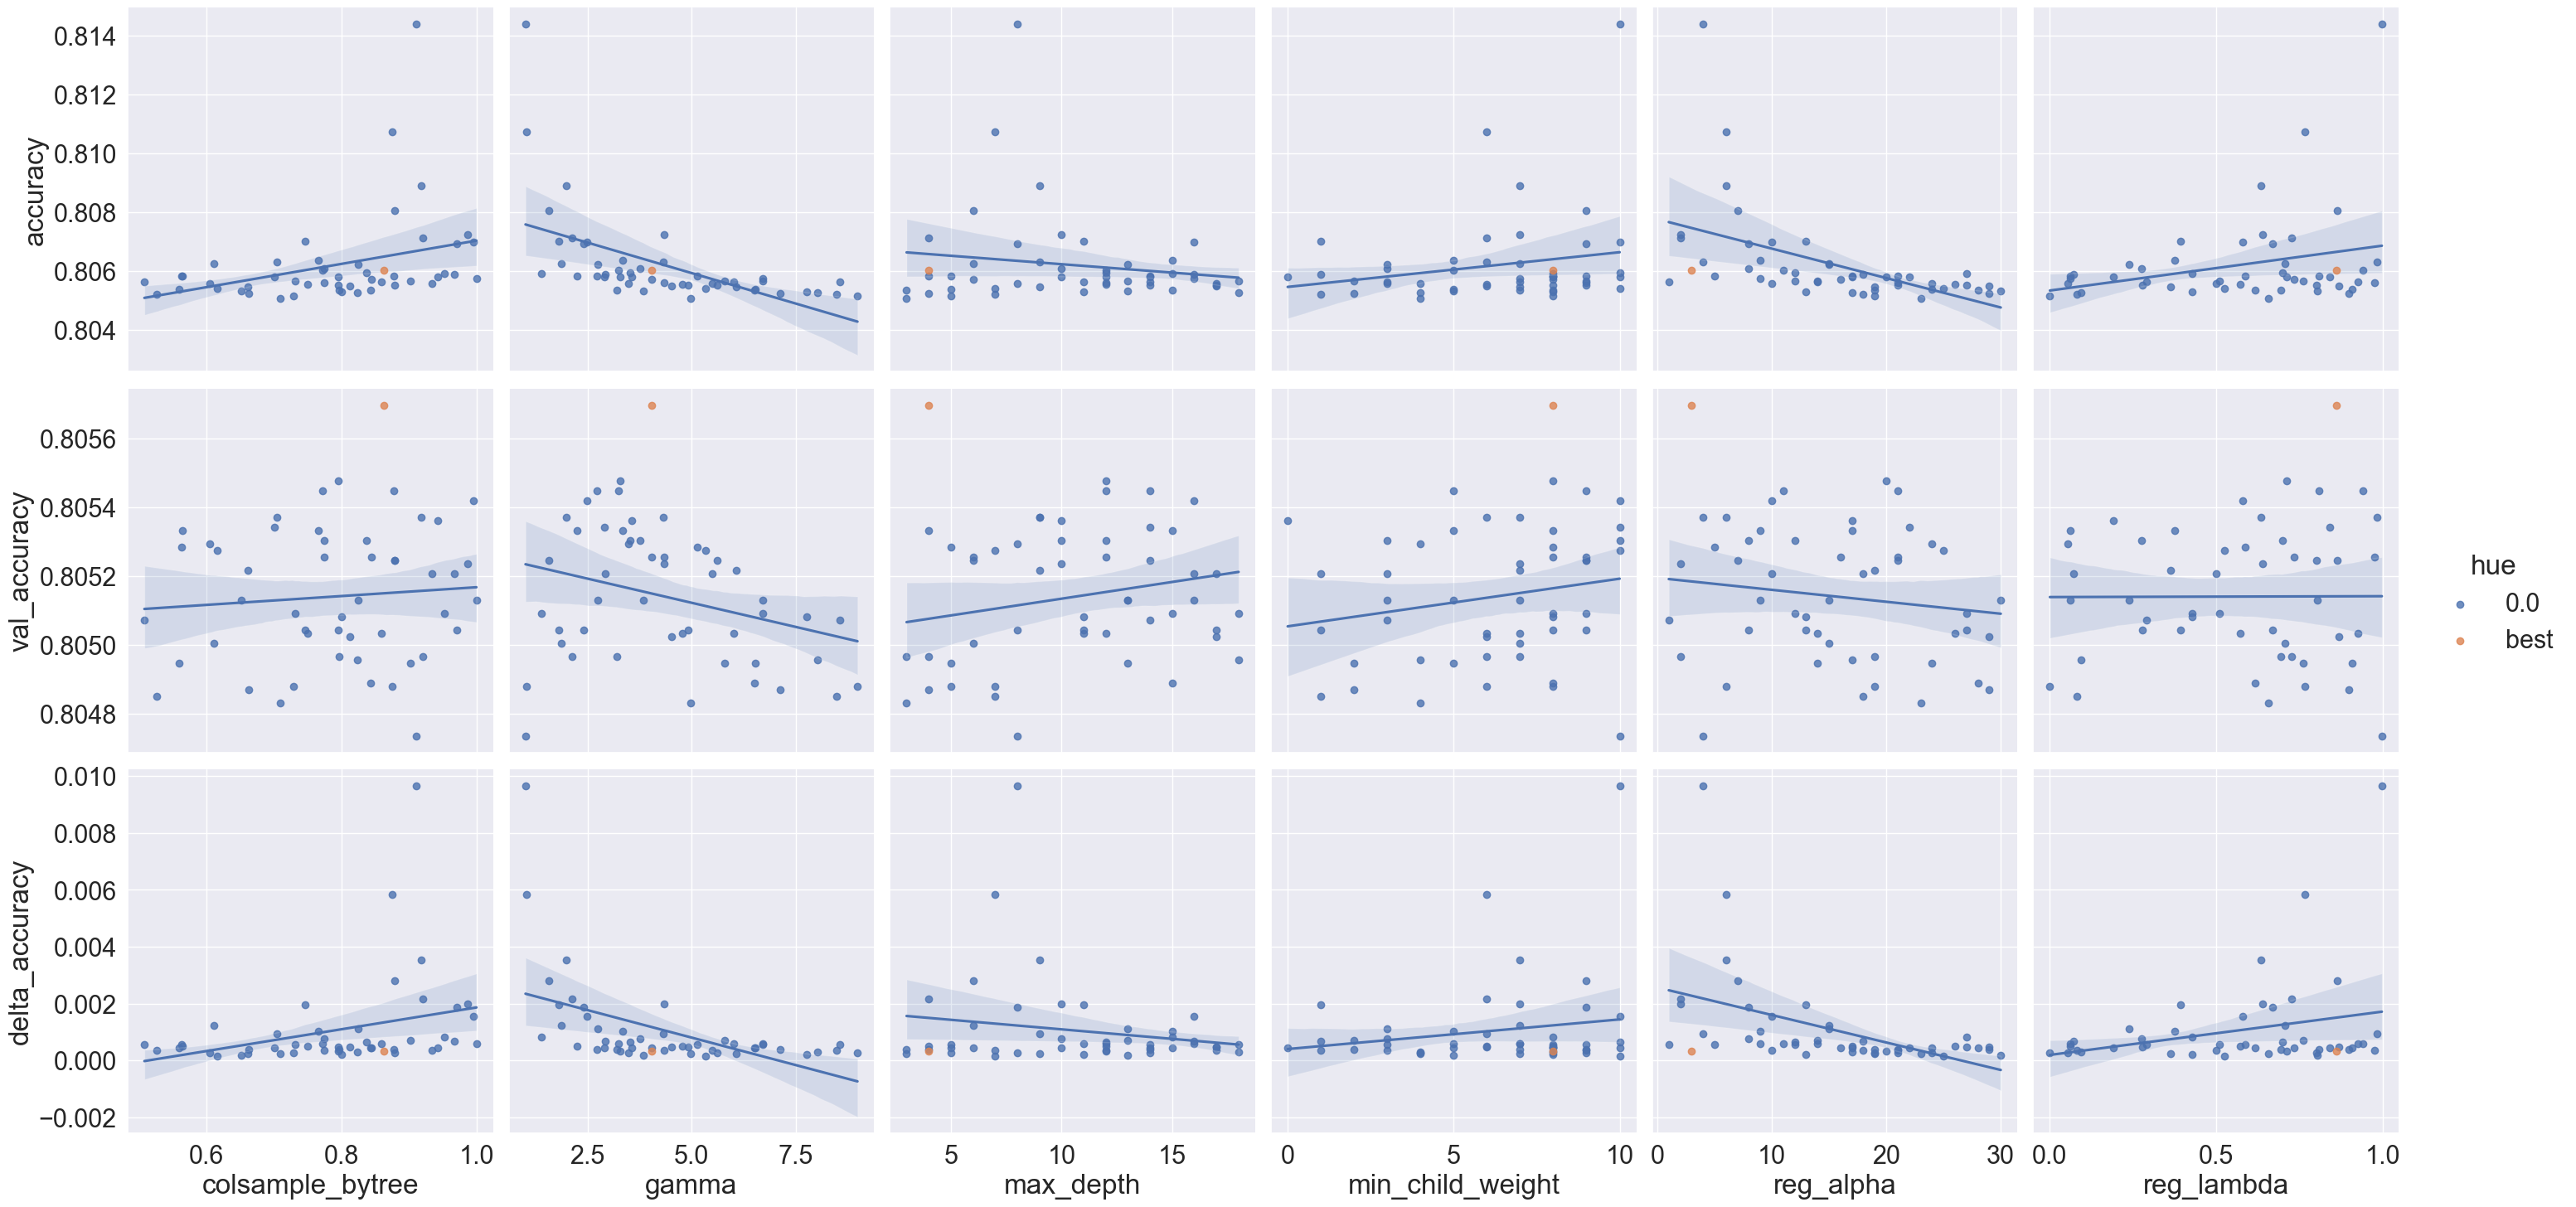

In [17]:
sns.set(font_scale = 2)
sns.pairplot(trial_res, x_vars=[ 'colsample_bytree', 'gamma', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5, hue = 'hue')
plt.show()
#sns.pairplot(trial_res.head(1), x_vars=[ 'colsample_bytree', 'gamma', 'max_depth', 'min_child_weight', 'reg_alpha', 'reg_lambda' ], y_vars=['accuracy','val_accuracy','delta_accuracy'], kind='reg',  height=5)

In [1]:
xgb_model=xgb.XGBClassifier(
                    n_estimators =180, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']))         
xgb_model.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])
#y_pred = xgb_model.predict(X_val[features])

NameError: name 'xgb' is not defined

In [ ]:
xgb_basic=xgb.XGBClassifier()      
xgb_basic.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])

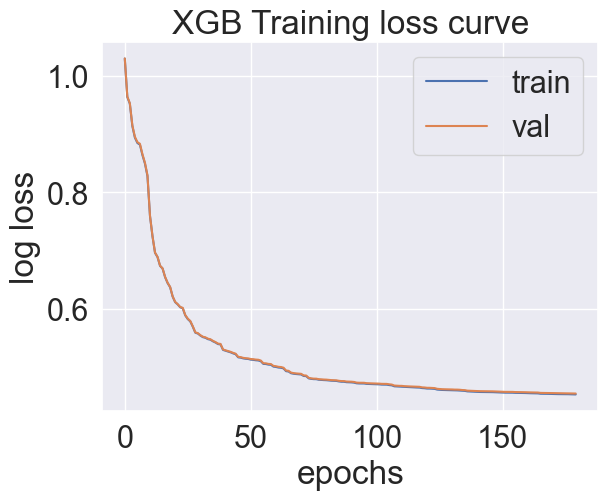

In [22]:
history  = xgb_model.evals_result()
plt.plot(history['validation_0']['mlogloss'], label='train')
plt.plot(history['validation_1']['mlogloss'], label='val')
plt.ylabel('log loss')
plt.xlabel('epochs')
plt.title('XGB Training loss curve')
plt.legend()

In [23]:
history  = xgb_model.evals_result()

In [24]:
history.keys()

dict_keys(['validation_0', 'validation_1'])

In [25]:
history['validation_0']

OrderedDict([('mlogloss',
              [1.029724694352257,
               0.9638110555502293,
               0.9521677625207794,
               0.9137845836566898,
               0.8940785762144752,
               0.8847672502157264,
               0.8819381811325054,
               0.8640621213637849,
               0.8493539932966732,
               0.8279898604501844,
               0.759495806415947,
               0.7244095203211033,
               0.6962253951657548,
               0.6887777942173964,
               0.6737902388321246,
               0.6691865394940449,
               0.6544271344920456,
               0.6442778392930002,
               0.6370599263207941,
               0.6210170016333977,
               0.6115029269638355,
               0.6076464958054125,
               0.6027012521485069,
               0.6010539449187092,
               0.5888522770552053,
               0.5824800342683667,
               0.5783833008667653,
               0.56935615432191

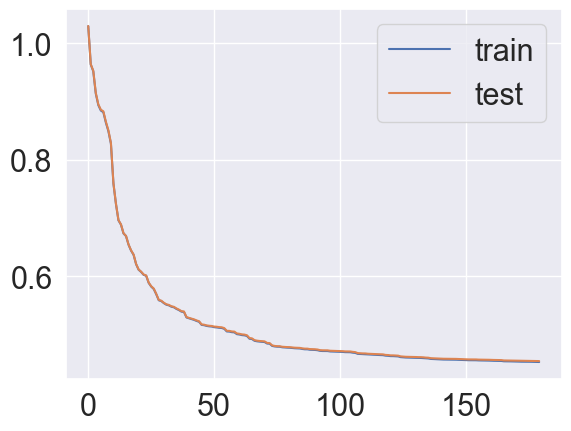

In [26]:
plt.plot(history['validation_0']['mlogloss'], label='train')
plt.plot(history['validation_1']['mlogloss'], label='test')
plt.legend()

NameError: name 'y_pred' is not defined

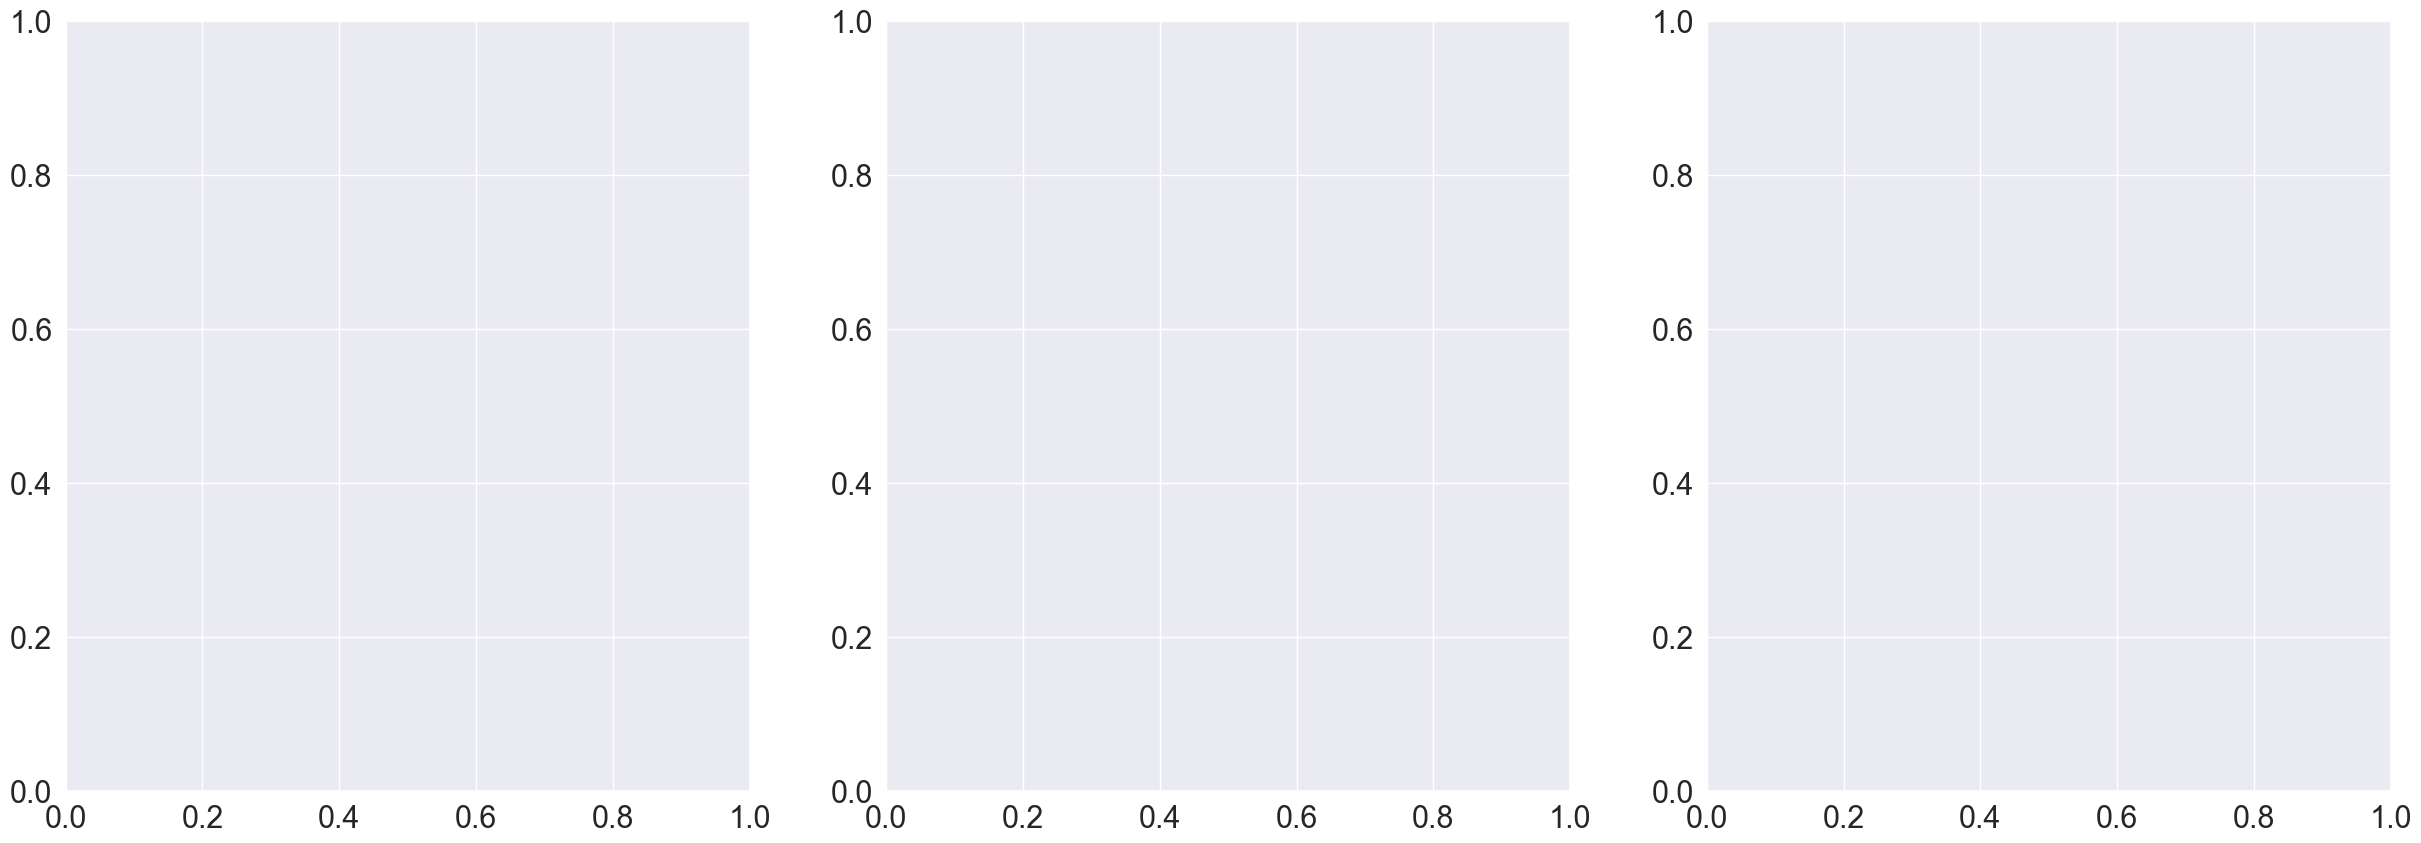

In [27]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))

#plt.legend()
#plt.xlim(-0.5, 2.5)
#plt.xticks(range(3)) 

In [ ]:
y_pred =  xgb_model.predict(X_val)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
bins = [-0.3, 0.7, 1.7, 2.7] 
bins2 = [0, 1, 2, 3] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    
    test_label_t = y_train[y_train==label]
    pred_label_t = y_pred_train[y_train==label]
    true_label_t = pred_label_t[pred_label_t == test_label_t]
    false_label_t= pred_label_t[pred_label_t != test_label_t]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label val ' + str(label), align = 'mid', width = 0.3, color = 'green')
    ax[i].hist(true_label_t[0:int(round(len(true_label_t)/3,0))] , bins = bins2, histtype = 'barstacked', alpha=0.5, label='True Label train ' + str(label), align = 'mid', width = 0.3, color = 'blue') 
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label val ' + str(label), align = 'mid', width = 0.3, color = 'red')
    ax[i].hist(false_label_t[0:int(round(len(false_label_t)/3,0))], bins = bins2, histtype = 'barstacked', alpha=0.5, label='False Label train ' + str(label), align = 'mid', width = 0.3, color = 'orange')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f' SVM Data with true label {i},Val Accuracy:{accuracy_score(test_label, pred_label):.3f},Train Accuracy:{accuracy_score(test_label_t, pred_label_t):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count normalised to validation')
    ax[i].legend()
    ax[i].set_xticks(range(3))